# 第6章: 機械学習

## 50. データの入手・整形

[News Aggregator Data Set](https://archive.ics.uci.edu/ml/datasets/News+Aggregator)をダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

1. ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
2. 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
3. 抽出された事例をランダムに並び替える．
4. 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．

In [1]:
import csv
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv("NewsAggregatorDataset/newsCorpora.csv", header=None, sep="\t", names=["ID", "TITLE", "URL", "PUBLISHER", "CATEGORY", "STORY", "HOSTNAME", "TIMESTAMP"])

a = ["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"]
b = data[data["PUBLISHER"].isin(a)]
c = b.loc[:, ["CATEGORY", "TITLE"]]

train, valid_test = train_test_split(c, train_size=0.8, shuffle=True)
valid, test = train_test_split(valid_test, train_size=0.5)

train.to_csv("NewsAggregatorDataset/train.txt", sep="\t", index=False)
valid.to_csv("NewsAggregatorDataset/valid.txt", sep="\t", index=False)
test.to_csv("NewsAggregatorDataset/test.txt", sep="\t", index=False)

学習データと評価データを作成したら，各カテゴリの事例数を確認せよ

In [3]:
print("[train]\n", train["CATEGORY"].value_counts())
print("[test]\n", test["CATEGORY"].value_counts())

[train]
 b    4502
e    4196
t    1229
m     745
Name: CATEGORY, dtype: int64
[test]
 b    570
e    543
t    141
m     80
Name: CATEGORY, dtype: int64


## 51. 特徴量抽出

学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
#単語の出現頻度を特徴量とする。

txt_vec = CountVectorizer()

#訓練データのみで計算したものをvalid, testに適応。単語は全て小文字に変換。
train_feature = txt_vec.fit_transform(train["TITLE"].str.lower())
valid_feature = txt_vec.transform(valid["TITLE"].str.lower())
test_feature = txt_vec.transform(test["TITLE"].str.lower())

with open("NewsAggregatorDataset/train.feature.txt", "w") as f:
    for d in train_feature.toarray():
        f.write("%s\n" % d)
with open("NewsAggregatorDataset/valid.feature.txt", "w") as f:
    for d in valid_feature.toarray()[0]:
        f.write("%s\n" % d)
with open("NewsAggregatorDataset/test.feature.txt", "w") as f:
    for d in test_feature.toarray()[0]:
        f.write("%s\n" % d)

## 52.学習

51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [7]:
#デフォルトの最大反復回数100だと収束しなかったため200に指定しました。-> 100と精度は変わらない…？
lr = LogisticRegression(random_state=42, max_iter=200) 
lr.fit(train_feature, train["CATEGORY"])

LogisticRegression(max_iter=200, random_state=42)

## 53. 予測

52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [8]:
def predictor(model, test_data):
    #return カテゴリ予測, 予測確率
    return model.predict(test_data), np.max(model.predict_proba(test_data), axis=1)

## 54. 正解率の計測

52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ

In [9]:
train_pred, train_probs = predictor(lr, train_feature)
test_pred, test_probs = predictor(lr, test_feature)

def calc_accu(original, predict):
    cm = confusion_matrix(original, predict)
    accuracy = sum([cm[i][i] for i in range(len(cm))]) / sum(map(sum, cm))
    return accuracy

print("Accuracy(train_data) : ", calc_accu(train["CATEGORY"], train_pred))
print("Accuracy(test_data) : ", calc_accu(test["CATEGORY"], test_pred))

Accuracy(train_data) :  0.9959707646176912
Accuracy(test_data) :  0.9160419790104948


## 55. 混同行列の作成

52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

学習データ(train)

In [10]:
category = ["b", "e", "t", "m"]
kind = ["train", "test", "valid"]

category_pre = ["Pred b", "Pred e", "Pred t", "Pred m"]
cm_train = confusion_matrix(train["CATEGORY"], train_pred)
pd.DataFrame(cm_train, columns=category_pre, index=category)

,Pred b,Pred e,Pred t,Pred m
b,4488,4,0,10
e,6,4189,0,1
t,2,3,740,0
m,15,2,0,1212


評価データ(test)

In [11]:
cm_test = confusion_matrix(test["CATEGORY"], test_pred)
pd.DataFrame(cm_test, columns=category_pre, index=category)

,Pred b,Pred e,Pred t,Pred m
b,541,17,3,9
e,5,533,1,4
t,11,16,51,2
m,27,14,3,97


## 56. 適合率，再現率，F1スコアの計測

52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [13]:
precision = precision_score(test["CATEGORY"], test_pred, average=None)
recall = recall_score(test["CATEGORY"], test_pred, average=None)
f1 = f1_score(test["CATEGORY"], test_pred, average=None)

precision = np.append(precision, precision_score(test["CATEGORY"], test_pred, average="micro"))
recall = np.append(recall, recall_score(test["CATEGORY"], test_pred, average="micro"))
f1 = np.append(f1, f1_score(test["CATEGORY"], test_pred, average="micro"))

precision = np.append(precision, precision_score(test["CATEGORY"], test_pred, average="macro"))
recall = np.append(recall, recall_score(test["CATEGORY"], test_pred, average="macro"))
f1 = np.append(f1, f1_score(test["CATEGORY"], test_pred, average="macro"))

pd.DataFrame(list(zip(precision, recall, f1)), index=category+["micro", "macro"], columns=["precision", "recall", "f1"])

,precision,recall,f1
b,0.926370,0.949123,0.937608
e,0.918966,0.981584,0.949243
t,0.879310,0.637500,0.739130
m,0.866071,0.687943,0.766798
micro,0.916042,0.916042,0.916042
macro,0.897679,0.814037,0.848195


## 57. 特徴量の重みの確認

52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

BEST

In [14]:
ranking = [str(i)+"位" for i in range(1,11)]
best = []

for i in range(len(category)):
    lst = sorted(list(zip(lr.coef_[i], txt_vec.get_feature_names_out())))
    best.append([lst[:10:-1][j][1] for j in range(10)])
pd.DataFrame(best, index=category, columns=ranking)

,1位,2位,3位,4位,5位,6位,7位,8位,9位,10位
b,bank,ecb,fed,ukraine,china,yellen,obamacare,argentina,buy,uber
e,kardashian,chris,paul,star,film,movie,thrones,aereo,trailer,george
t,ebola,fda,cancer,mers,study,drug,cases,cigarettes,doctors,brain
m,google,facebook,apple,microsoft,climate,heartbleed,tesla,nasa,gm,comcast


WORST

In [15]:
worst = []
for i in range(len(category)):
    lst = sorted(list(zip(lr.coef_[i], txt_vec.get_feature_names_out())))
    worst.append([lst[:10][j][1] for j in range(10)])
pd.DataFrame(worst, index=category, columns=ranking)

,1位,2位,3位,4位,5位,6位,7位,8位,9位,10位
b,aereo,activision,heartbleed,ebola,nintendo,cap,people,star,subscription,virus
e,google,facebook,gm,china,microsoft,study,billion,climate,data,ceo
t,gm,ceo,facebook,apple,twitter,google,climate,jpmorgan,alibaba,game
m,stocks,expands,fed,drug,quarter,thrones,percent,american,should,board


## 58. 正則化パラメータの変更

ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

In [16]:
import matplotlib.pyplot as plt

In [17]:
def buildModel_and_calcScore(param, feature_data, original_data, solver="lbfgs"):
    lr = LogisticRegression(random_state=42, max_iter=20000, C=param, solver=solver) 
    lr.fit(train_feature, train["CATEGORY"])
    pred, probs = predictor(lr, feature_data)
    return calc_accu(original_data, pred)

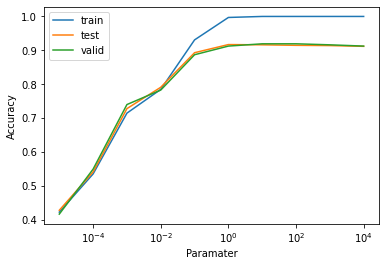

In [18]:
feature = [train_feature, test_feature, valid_feature]
original = [train["CATEGORY"], test["CATEGORY"], valid["CATEGORY"]]

params = np.logspace(-5, 4, 10, base=10)
accu_list = []

for i in range(3):
    accu_list.append([buildModel_and_calcScore(p, feature[i], original[i]) for p in params])
    plt.plot(params, accu_list[i], label=kind[i])

plt.xscale("log")
plt.ylabel("Accuracy")
plt.xlabel("Paramater")
plt.legend()
plt.show()

## 59. ハイパーパラメータの探索

学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [19]:
def for_allkind_buildModel_and_calcScore(param, solver="lbfgs"):
    score = []
    
    for i in range(3):
        score.append(buildModel_and_calcScore(param, feature[i], original[i]))
    
    return score

In [20]:
solver = ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
max_valid_acc = 0

for s in solver:
    accu_list = []
    for p in params:
        tmp = for_allkind_buildModel_and_calcScore(p, s)
        if max_valid_acc < tmp[2]:
            max_valid_acc = tmp[2]
            max_solver = s
            max_param = p

print("solver : ", max_solver)
print("parameter : ", max_param)
print("accuracy : ", max_valid_acc)

solver :  newton-cg
parameter :  10.0
accuracy :  0.9182908545727136
